In [12]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

import glob

from PIL import Image
from tqdm import tqdm

from concurrent.futures import ThreadPoolExecutor, as_completed


## Preprocess all files
Location: work/image/[sub]/[file].png

In [2]:
def get_files(type):
    src_files = glob.glob(f"input/{type}/*.wav")
    dst_files = [os.path.split(file) for file in src_files]
    dst_files = [(path.split("/")+file.split(".")) for (path, file) in dst_files]
    dst_files = [(os.path.join("work",f[1],f"{f[2]}/ft.png"),
                os.path.join("work",f[1],f"{f[2]}/mel.png"),
                os.path.join("work",f[1],f"{f[2]}/cqt.png")) for f in dst_files]
    audio_files = [(src_files[i],dst_files[i]) for i in range(len(src_files))]
    
    return audio_files

audio_files = get_files("trn_curated")
audio_files[0]

('input/trn_curated/ffe2178b.wav',
 ('work/trn_curated/ffe2178b/ft.png',
  'work/trn_curated/ffe2178b/mel.png',
  'work/trn_curated/ffe2178b/cqt.png'))

In [10]:
def read_audio(pathname, trim_long_data, length):
    y, sr = librosa.load(pathname, sr=44100)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > length * sr: # long enough
        if trim_long_data:
            y = y[0:0+length * sr]
    else: # pad blank
        padding = length * sr - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, length * sr - len(y) - offset), 'constant')
    return y, sr


def to_image(pathname, trim_long_data=False, length=2):
    # load file
    y, sr = read_audio(pathname, trim_long_data, length)

    # STFT
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    # Mel Spectrum
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

    # CQT
    C = librosa.cqt(y, sr=sr)
    C_db = librosa.amplitude_to_db(abs(C), ref=np.max)

    # Normalization
    S_db = np.clip(S_db, -80, 0)
    S_db = 65535 * (S_db + 80) / 80.0

    S_db_mel = np.clip(S_db_mel, -80, 0)
    S_db_mel = 65535 * (S_db_mel + 80) / 80.0

    C_db = np.clip(C_db, -80, 0)
    C_db = 65535 * (C_db + 80) / 80.0

    # to image
    S_db = Image.fromarray(S_db.astype(np.uint16))
    S_db_mel = Image.fromarray(S_db_mel.astype(np.uint16))
    C_db = Image.fromarray(C_db.astype(np.uint16))

    return S_db, S_db_mel, C_db


def process_one(args):
    src_path, dst_triplet = args
    stft_path, mel_path, cqt_path = dst_triplet
    os.makedirs(os.path.split(stft_path)[0], exist_ok=True)
    stft, mel, cqt = to_image(src_path)
    stft.save(stft_path)
    mel.save(mel_path)
    cqt.save(cqt_path)

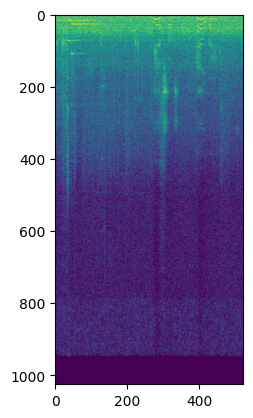

In [13]:
stft,mel,cqt = to_image('input/trn_curated/ffe2178b.wav')
plt.imshow(stft)
plt.show()

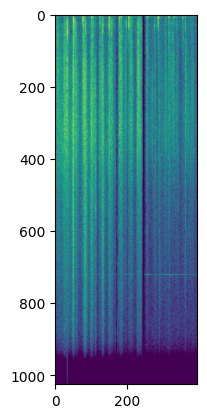

In [15]:
stft,mel,cqt = to_image(audio_files[2][0])
plt.imshow(stft)
plt.show()

In [10]:
max_workers = 10

In [11]:
# process trn_curated
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(process_one, t) for t in get_files("trn_curated")]
    for _ in tqdm(as_completed(futures), total=len(futures), desc="Processing"):
        pass

Processing: 100%|██████████| 4970/4970 [04:13<00:00, 19.62it/s]


In [ ]:
# process train_noisy
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(process_one, t) for t in get_files("train_noisy")]
    for _ in tqdm(as_completed(futures), total=len(futures), desc="Processing"):
        pass

Processing:   0%|          | 65/19815 [00:04<17:41, 18.61it/s] 